In [4]:
# Charger le fichier HDF5
file_name =  r'C:\Users\Amina\Downloads\RadioML_dataset\GOLD_XYZ_OSC.0001_1024.hdf5'
f = h5py.File(file_name, 'r')

# Explorer la structure des groupes dans le fichier
print("Groupes dans le fichier HDF5 :", list(f.keys()))

Groupes dans le fichier HDF5 : ['X', 'Y', 'Z']


In [3]:
import h5py

# Ouvrir le fichier HDF5
with h5py.File(file_name) as f:
    iq_samples = f['X'][:10]  # Récupérer seulement les 10 premiers échantillons
    labels = f['Y'][:10]  # Étiquettes pour les 10 premiers échantillons
    snr_values = f['Z'][:10]  # Valeurs SNR pour les 10 premiers échantillons

# Afficher les échantillons et les étiquettes
for i in range(10):
    print(f"Sample {i+1}: I/Q = {iq_samples[i]}, Label = {labels[i]}, SNR = {snr_values[i]}")

Sample 1: I/Q = [[ 0.0420274   0.23476323]
 [-0.2728826   0.40513492]
 [-0.26707262  0.22749889]
 ...
 [-0.7055947  -0.28693035]
 [-0.41157472  0.66826206]
 [ 0.06487698  0.6358149 ]], Label = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], SNR = [-20]
Sample 2: I/Q = [[ 1.198624    0.4493616 ]
 [ 0.48543093  0.28272954]
 [ 0.8679219  -0.33194578]
 ...
 [-1.2129315  -0.64293194]
 [-0.38100415  0.793629  ]
 [ 0.0864124   1.0921808 ]], Label = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], SNR = [-20]
Sample 3: I/Q = [[-0.22345497  0.18144214]
 [ 0.06201788 -0.934319  ]
 [ 0.71949023  0.21791682]
 ...
 [ 0.7598529   0.00820714]
 [ 0.3396765   0.12928951]
 [ 0.58232504  0.10775959]], Label = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], SNR = [-20]
Sample 4: I/Q = [[ 0.37628508 -1.0977991 ]
 [-0.8325528   0.85677695]
 [ 0.6864274  -0.05160137]
 ...
 [-0.59402794 -1.0192018 ]
 [-0.03996986  0.6050206 ]
 [-1.1834852  -0.8250115 ]], Label = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

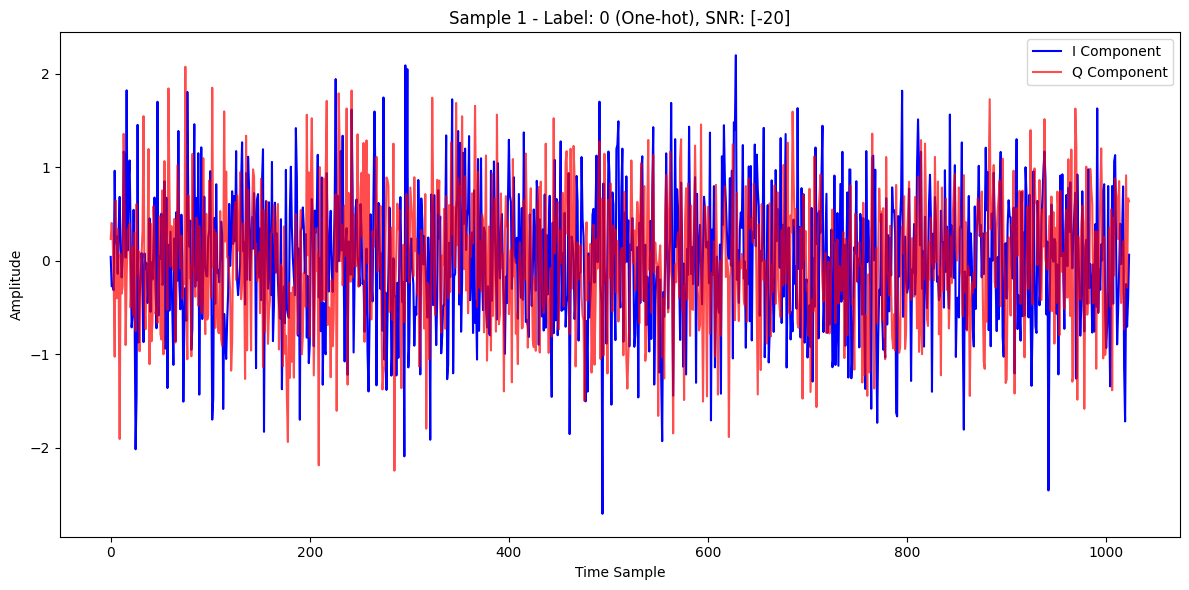

In [5]:
import matplotlib.pyplot as plt

# Sélectionner le premier échantillon
I_component = iq_samples[0][:, 0]  # Composante I du premier échantillon
Q_component = iq_samples[0][:, 1]  # Composante Q du premier échantillon

# Créer la figure et les tracés pour les composantes I et Q
plt.figure(figsize=(12, 6))
plt.plot(I_component, label="I Component", color="blue")
plt.plot(Q_component, label="Q Component", color="red", alpha=0.7)

# Ajouter le titre, les légendes et les labels
plt.title(f"Sample 1 - Label: {labels[0].argmax()} (One-hot), SNR: {snr_values[0]}")
plt.xlabel("Time Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

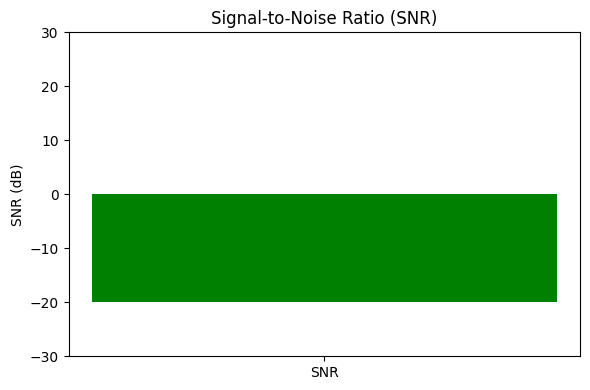

In [7]:
snr_value = snr_values[0][0]       # Valeur de SNR du premier échantillon

# Deuxième figure : Visualisation de la valeur de SNR
plt.figure(figsize=(6, 4))
plt.bar(["SNR"], [snr_value], color="green")
plt.title("Signal-to-Noise Ratio (SNR)")
plt.ylabel("SNR (dB)")
plt.ylim(-30, 30)  # Ajuster les limites si nécessaire
plt.tight_layout()

# Afficher les figures
plt.show()

In [9]:
print(f['X'].shape)  # Dimensions de IQ
print(f['Y'].shape)  # Dimensions des Labels
print(f['Z'].shape)  # Dimensions de SNR

(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)


In [22]:
import h5py
import numpy as np
from collections import Counter

In [ ]:
batch_size = 50000  # Taille du lot à traiter en mémoire
snr_threshold = 10  # Seuil SNR
final_sample_size = 100000  # Nombre d'échantillons à sélectionner
top_modulations_count = 7  # Nombre de modulations les plus fréquentes

In [33]:
# Chemin vers le dataset initial
file_path = r'C:\Users\Amina\Downloads\RadioML_dataset\GOLD_XYZ_OSC.0001_1024.hdf5'

# Liste pour stocker les indices des échantillons filtrés
filtered_indices = []

In [34]:
# Parcourir les données par lot pour stocker les indices d'échantillons qui répondent aux critères
with h5py.File(file_path, 'r') as f:
    total_samples = f['X'].shape[0]
    num_batches = int(np.ceil(total_samples / batch_size))
    
    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, total_samples)
        
        # Charger un lot de données
        snr_values_batch = f['Z'][start:end]
        labels_batch = f['Y'][start:end]
        
        # Filtrer les indices avec SNR > 10 dans le lot actuel
        high_snr_indices = np.where(snr_values_batch > snr_threshold)[0]
        high_snr_indices = high_snr_indices + start  # Ajuster pour l'indexation globale
        
        # Stocker les indices filtrés
        filtered_indices.extend(high_snr_indices)

In [35]:
# Identifier les modulations les plus fréquentes parmi les échantillons filtrés
with h5py.File(file_path, 'r') as f:
    decoded_labels = [np.argmax(f['Y'][idx]) for idx in filtered_indices]
    modulation_counts = Counter(decoded_labels)
    top_modulations = [mod for mod, _ in modulation_counts.most_common(top_modulations_count)]
    print(f"Modulations les plus fréquentes sélectionnées : {top_modulations}")

Modulations les plus fréquentes sélectionnées : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


In [37]:
# Filtrer les indices pour n’inclure que les échantillons des modulations fréquentes
with h5py.File(file_path, 'r') as f:
    final_filtered_indices = [
        idx for idx in filtered_indices if np.argmax(f['Y'][idx]) in top_modulations
    ]

In [38]:
# Sélectionner 100 000 indices aléatoirement parmi les indices filtrés dans le fichier temporaire
selected_indices = np.random.choice(final_filtered_indices, final_sample_size, replace=False)

In [40]:
selected_indices = np.sort(selected_indices)

# Charger et sauvegarder les échantillons finaux
new_file_path = r'C:\Users\Amina\Downloads\RadioML_dataset\Filtered_RadioML_dataset_100k_snr10_top7.hdf5'
with h5py.File(file_path, 'r') as f, h5py.File(new_file_path, 'w') as f_new:
    # Créer les datasets finaux avec les échantillons sélectionnés
    f_new.create_dataset('X', data=f['X'][selected_indices])
    f_new.create_dataset('Y', data=f['Y'][selected_indices])
    f_new.create_dataset('Z', data=f['Z'][selected_indices])

In [43]:
# Ouvrir le fichier et afficher les dimensions des datasets
with h5py.File(new_file_path, 'r') as f:
    print(f['X'].shape)  # Dimensions de IQ
    print(f['Y'].shape)  # Dimensions des Labels
    print(f['Z'].shape)  # Dimensions de SNR

(100000, 1024, 2)
(100000, 24)
(100000, 1)


In [41]:
import h5py
import numpy as np

# Chemin vers le nouveau dataset HDF5
new_file_path = r'C:\Users\Amina\Downloads\RadioML_dataset\Filtered_RadioML_dataset_100k_snr10_top7.hdf5'

# Ouvrir le fichier HDF5 et lire les données
with h5py.File(new_file_path, 'r') as f:
    # Charger les valeurs de SNR et les labels de modulation
    snr_values = f['Z'][:]
    labels = f['Y'][:]

# Liste des noms de modulation (ajustée pour les indices du dataset)
modulation_names = [
    'BPSK', 'QPSK', '8PSK', 'AM-DSB', 'AM-SSB', 'CPFSK', 'GFSK',
    'PAM4', 'QAM16', 'QAM64', 'WBFM', 'AM', 'SSB', 'PSK', 'FM', 
    'GMSK', 'DPSK', 'OFDM', 'OQPSK', 'AM-DSBSC', 'AM-SSBSC', 
    'ASK', 'FSK', 'MSK'
]

# Décoder les labels pour obtenir les noms de modulation
decoded_modulations = [modulation_names[np.argmax(label)] for label in labels]

# Afficher aléatoirement des valeurs de SNR et des modulations
random_indices = np.random.choice(len(snr_values), 10, replace=False)  # Sélectionner 10 indices aléatoires

print("Valeurs de SNR et modulations aléatoires :")
for idx in random_indices:
    print(f"SNR: {snr_values[idx][0]}, Modulation: {decoded_modulations[idx]}")

# Afficher toutes les modulations existantes dans le dataset
unique_modulations = set(decoded_modulations)
print("\nToutes les modulations existantes dans le dataset :")
print(unique_modulations)


Valeurs de SNR et modulations aléatoires :
SNR: 22, Modulation: 8PSK
SNR: 24, Modulation: AM-SSB
SNR: 14, Modulation: AM-DSB
SNR: 20, Modulation: AM-DSB
SNR: 26, Modulation: GFSK
SNR: 22, Modulation: BPSK
SNR: 30, Modulation: GFSK
SNR: 24, Modulation: CPFSK
SNR: 22, Modulation: BPSK
SNR: 30, Modulation: BPSK

Toutes les modulations existantes dans le dataset :
{'GFSK', '8PSK', 'AM-SSB', 'AM-DSB', 'QPSK', 'BPSK', 'CPFSK'}


In [44]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [45]:
# Charger les données
with h5py.File(new_file_path, 'r') as f:
    iq_samples = f['X'][:]       # Données IQ
    labels = f['Y'][:]           # Labels des modulations
    snr_values = f['Z'][:]       # Valeurs de SNR

In [46]:
# Suppression des doublons
unique_indices = np.unique(iq_samples, axis=0, return_index=True)[1]
iq_samples = iq_samples[unique_indices]
labels = labels[unique_indices]
snr_values = snr_values[unique_indices]

In [47]:
# Normalisation des données IQ
scaler = StandardScaler()
iq_samples = iq_samples.reshape(-1, 1024 * 2)  # Aplatir pour la normalisation
iq_samples = scaler.fit_transform(iq_samples)
iq_samples = iq_samples.reshape(-1, 1024, 2)  # Reshape pour LSTM

In [48]:
# Décoder les labels one-hot en indices de classes
decoded_labels = np.array([np.argmax(label) for label in labels])

# Conversion des labels en catégories pour l’entraînement
num_classes = len(np.unique(decoded_labels))
categorical_labels = to_categorical(decoded_labels, num_classes=num_classes)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(iq_samples, categorical_labels, test_size=0.2, random_state=42)

In [50]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(1024, 2), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\Amina\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2611s 3s/step - accuracy: 0.3124 - loss: 1.4085 - val_accuracy: 0.3431 - val_loss: 1.1614
Epoch 2/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2305s 2s/step - accuracy: 0.3034 - loss: 1.4694 - val_accuracy: 0.3397 - val_loss: 1.2464
Epoch 3/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2319s 2s/step - accuracy: 0.3347 - loss: 1.2989 - val_accuracy: 0.2693 - val_loss: 1.5195
Epoch 4/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2422s 2s/step - accuracy: 0.3374 - loss: 1.2681 - val_accuracy: 0.3696 - val_loss: 1.1512
Epoch 5/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2308s 2s/step - accuracy: 0.3709 - loss: 1.1647 - val_accuracy: 0.3880 - val_loss: 1.1454
Epoch 6/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2859s 3s/step - accuracy: 0.3877 - loss: 1.1706 - val_accuracy: 0.2802 - val_loss: 1.7248
Epoch 7/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2503s 2s/step - accuracy: 0.3244 - loss: 1.3868 - val_accuracy: 0.3457 - val_loss: 1.3324
Epoch 8/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3601s 3s/step - accuracy: 0.3663 -

In [53]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Sauvegarder le modèle
model.save('lstm_model.h5')

518/518 ━━━━━━━━━━━━━━━━━━━━ 154s 295ms/step - accuracy: 0.8563 - loss: 0.3075


Test Loss: 0.3050439953804016, Test Accuracy: 0.8572894930839539


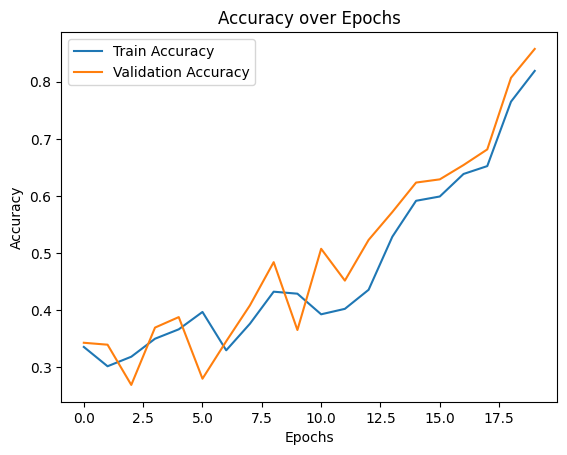

In [54]:
# Tracer l’évolution de l'entraînement
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
